# Exercise: Handwritten digit classification

This exercise is independent of the example given by the teacher `unit3_example_mlp_mnist.ipynb` and is developed following the [Keras introduction for engineers](https://keras.io/getting_started/intro_to_keras_for_engineers/).

Basic imports:

In [2]:
import numpy as np
import os

os.environ["KERAS_BACKEND"] = 'tensorflow'

import keras

print(keras.__version__)
print(np.__version__)

3.5.0
1.26.4


Loading data:

In [3]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

Exploring the data:

In [4]:
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
print(type(x_train), type(y_train), type(x_test), type(y_test))
print(x_train.dtype, y_train.dtype, x_test.dtype, y_test.dtype)
print(x_train.max(), x_train.min(), x_test.max(), x_test.min())
print(y_train.max(), y_train.min(), y_test.max(), y_test.min())

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
uint8 uint8 uint8 uint8
255 0 255 0
9 0 9 0


Scaling the images to 0-1 interval:

In [5]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

Adding a new dimension that represent the channel. Since we are operating in grayscale there is only one channel. If the image were colorful, we would probably have three channels (RGB).

In [6]:
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

In [7]:
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

x_train shape: (60000, 28, 28, 1)
y_train shape: (60000,)
60000 train samples
10000 test samples


Example of a point more or less in the middle of the image. Notice that it is a tensor of shape 1, since there is only the grayscale channel.

In [8]:
x_train[0, 14, 14]

array([0.9411765], dtype=float32)

A nice way to visualize the individual images is using [Pillow (PIL)](https://github.com/python-pillow/Pillow):

In [67]:
import PIL
from PIL import Image
import IPython
from IPython.display import display
from random import randrange

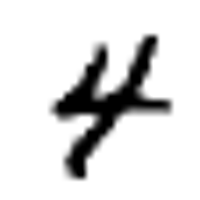

4

In [64]:
sample_index = randrange(len(x_train)) # Selecting a random index

sample = x_train[sample_index] # Selecting the image corresponding to the previous index

sample_2d = (255 * sample.squeeze(axis = -1)).astype(np.uint8) # Scale the image back to 0-255 pixel range and removing last dimension
                                                            # i.e. convert from (28, 28, 1) to (28, 28) 

sample_image = Image.fromarray(sample_2d, mode='L') # Create image from array

sample_image = sample_image.resize((200, 200)) # Increase image size to proper display

sample_image = Image.eval(sample_image, lambda x: 255 - x) # Inverts the grayscale


display(sample_image) # Show image
y_train[sample_index] # Show label

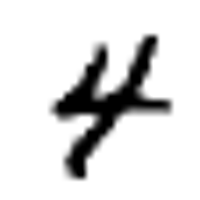

In [69]:
# Function concentrating all the previous logic

def display_with_pil(image: np.typing.NDArray):
    if image.ndim == 3:
        image = sample.squeeze(axis = -1)

    if 0 <= image.min() and image.max() <= 1:
        image = (255 * image).astype(np.uint8)

    image = PIL.Image.fromarray(image, mode = 'L')
    image = image.resize((200, 200))
    image = PIL.Image.eval(image, lambda x: 255 - x)

    IPython.display.display(image)

display_with_pil(sample)

Another useful way to "display" the image is by using a [pandas](https://pandas.pydata.org/) dataframe. This idea came from the book [Deep Learning for Coders with Fastai and PyTorch, 2020, by Jeremy Howard, page 136](https://course.fast.ai/Resources/book.html). Although pandas is a bit old for datascience applications given the rise of [Polars](https://docs.pola.rs/), the latter (Polars) do not have this nice feature of `background_gradient`:

In [41]:
import pandas as pd

df_sample = pd.DataFrame(sample_2d)

df_sample.style.set_properties(**{'font-size': '6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,8,76,199,255,255,245,146,146,89,13,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,41,197,253,253,253,253,253,253,253,253,159,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,1,122,237,253,253,253,252,248,248,248,248,251,245,86,0,0,0,0,0,0
8,0,0,0,0,0,0,0,1,126,253,253,206,102,194,81,0,0,0,0,135,253,212,3,0,0,0,0,0
9,0,0,0,0,0,0,0,6,253,253,211,25,0,0,0,0,0,0,0,55,253,253,5,0,0,0,0,0


Creating the model:

In [27]:
# Model parameters
num_classes = 10
input_shape = (28, 28, 1)

model = keras.Sequential(
    [
        keras.layers.Input(shape=input_shape),
        keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Conv2D(128, kernel_size=(3, 3), activation="relu"),
        keras.layers.Conv2D(128, kernel_size=(3, 3), activation="relu"),
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(num_classes, activation="softmax"),
    ]
)

In [28]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 10, 10, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 260,298 (1016.79 KB)

 Trainable params: 260,298 (1016.79 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    metrics=[
        keras.metrics.SparseCategoricalAccuracy(name="acc"),
    ],
)

In [31]:
batch_size = 128
epochs = 5

callbacks = [
    keras.callbacks.ModelCheckpoint(filepath="model_at_epoch_{epoch}.keras"),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=2),
]

model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.15,
    callbacks=callbacks,
)
score = model.evaluate(x_test, y_test, verbose=0)

Epoch 1/5


2024-10-02 15:44:22.207441: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 159936000 exceeds 10% of free system memory.


399/399 ━━━━━━━━━━━━━━━━━━━━ 105s 262ms/step - acc: 0.9832 - loss: 0.0551 - val_acc: 0.9924 - val_loss: 0.0281
Epoch 2/5
399/399 ━━━━━━━━━━━━━━━━━━━━ 103s 257ms/step - acc: 0.9834 - loss: 0.0552 - val_acc: 0.9920 - val_loss: 0.0280
Epoch 3/5
399/399 ━━━━━━━━━━━━━━━━━━━━ 103s 257ms/step - acc: 0.9827 - loss: 0.0579 - val_acc: 0.9913 - val_loss: 0.0323
Epoch 4/5
399/399 ━━━━━━━━━━━━━━━━━━━━ 102s 256ms/step - acc: 0.9842 - loss: 0.0507 - val_acc: 0.9918 - val_loss: 0.0311


In [32]:
model.save("final_model.keras")

In [33]:
model = keras.saving.load_model("final_model.keras")

Testing the model:

In [89]:
import matplotlib.pyplot as plt

def plot_prediction(prediction: np.typing.NDArray):
    if prediction.ndim == 2:
        prediction = prediction[0]
    classes = np.arange(len(prediction))
    plt.bar(classes, prediction)
    plt.xticks(classes)
    plt.show()

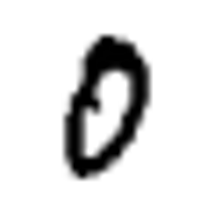

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


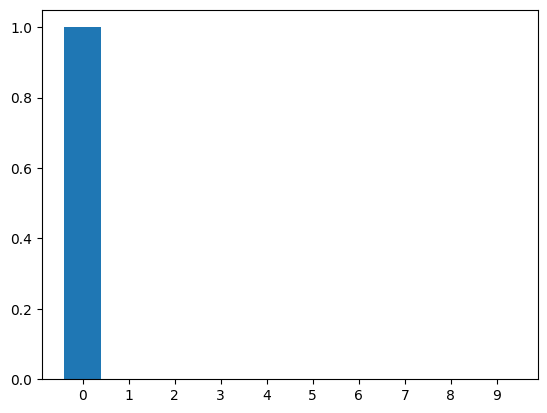

(None, None)

In [93]:
sample_index = randrange(len(x_test)) # Selecting a random index
sample = x_test[sample_index] # Selecting the image corresponding to the previous index

display_with_pil(sample), plot_prediction(model.predict(np.array([sample])))